In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
url = 'https://raw.githubusercontent.com/Trashure-C241-PS226/ML/main/Mobile%20phone%20price.csv'
data  = pd.read_csv(url)

In [3]:
label_encoders = {}
categorical_columns = ['Brand', 'Model']
for column in categorical_columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

In [4]:
def convert_memory_size(memory):
    if 'GB' in memory:
        return int(memory.replace('GB', ''))
    elif 'MB' in memory:
        return int(memory.replace('MB', ''))
    return int(memory)


In [5]:
data['Storage '] = data['Storage '].apply(convert_memory_size)
data['RAM '] = data['RAM '].apply(convert_memory_size)

data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(' ', '_')

# data = data.drop(['Brand'], axis=1)
# data = data.drop(['Model'], axis=1)
# data = data.drop(['Screen_Size_(inches)'], axis=1)
# data = data.drop(['Camera_(MP)'], axis=1)
# data = data.drop(['Battery_Capacity_(mAh)'], axis=1)




data["Camera_(MP)"] = data["Camera_(MP)"].str.replace("MP","")
data["Camera_(MP)"] = data["Camera_(MP)"].str.replace("D","")

data["Camera_(MP)"] = data["Camera_(MP)"].str.split("+")

data = data[~(data["Screen_Size_(inches)"] == "7.6 (unfolded)")]
data = data[~(data["Screen_Size_(inches)"] == "6.8 + 3.9")]
data["Screen_Size_(inches)"] = data["Screen_Size_(inches)"].astype("float64")

listx = []
for i in data.index:
    listx.append(data["Camera_(MP)"][i][0])

data["Camera_(MP)"] = listx
data["Camera_(MP)"] = data["Camera_(MP)"].astype("float64")

data['Price_($)'] = data['Price_($)'].str.replace('$','')
data['Brand'] = data['Brand'].astype("float64")
data['Storage'] = data['Storage'].astype("float64")
data['RAM'] = data['RAM'].astype("float64")
data['Battery_Capacity_(mAh)'] = data['Battery_Capacity_(mAh)'].astype("float64")
data['Price_($)'] = data['Price_($)'].str.replace(',','')
data['Price_($)'] = data['Price_($)'].astype("float64")

In [6]:
desc = data['Price_($)'].describe()

# Tentukan batas kategori
q1 = desc['25%']
q2 = desc['50%']
q3 = desc['75%']

# Define price ranges for each class
price_ranges = [
    (desc['min'], q1),
    (q1, q2),
    (q2, q3),
    (q3, desc['max'])
]

# Fungsi untuk mengkategorikan harga
def categorize_price(price):
    if price < q1:
        return 0
    elif q1 <= price < q2:
        return 1
    elif q2 <= price < q3:
        return 2
    else:
        return 3

# Terapkan fungsi pengategorian
data['Category'] = data['Price_($)'].apply(categorize_price)

In [7]:
data['Category'].value_counts()


Category
1    108
2    104
3    102
0     91
Name: count, dtype: int64

In [8]:
data = data.drop(['Price_($)'], axis=1)

In [ ]:
data

,Brand,Model,Storage,RAM,Screen_Size_(inches),Camera_(MP),Battery_Capacity_(mAh),Category
0,0.0,232,128.0,6.0,6.10,12.0,3095.0,3
1,12.0,100,256.0,12.0,6.80,108.0,5000.0,3
2,9.0,19,128.0,8.0,6.70,48.0,4500.0,3
3,15.0,178,128.0,6.0,6.67,64.0,5020.0,1
4,4.0,162,128.0,8.0,6.40,50.0,4614.0,3
...,...,...,...,...,...,...,...,...
402,12.0,95,128.0,8.0,6.70,12.0,4300.0,3
403,15.0,111,128.0,6.0,6.57,48.0,4160.0,2
404,0.0,229,128.0,6.0,6.70,12.0,3687.0,3
405,10.0,188,128.0,8.0,6.40,48.0,4025.0,2


In [9]:
features = data.drop(columns=['Category'])
target = data['Category']

scaler = StandardScaler()
features = scaler.fit_transform(features)
# target_log = np.log1p(target)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [10]:
y_train

356    0
235    1
3      1
18     2
132    3
      ..
71     1
107    0
271    1
349    1
103    3
Name: Category, Length: 324, dtype: int64

In [11]:
input_dim = X_train.shape[1]

model = Sequential([
    Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2, batch_size=32, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1

In [12]:
loss = model.evaluate(X_test, y_test)
print(f'Final loss: {loss}')

3/3 [==============================] - 0s 4ms/step - loss: 0.7408 - accuracy: 0.8148
Final loss: [0.7407584190368652, 0.8148148059844971]


In [13]:
new_data_dict = {
    'Brand': ['Apple'],
    'Model': ['iPhone 12 Mini'],
    'Storage': ['128 GB'],
    'RAM': ['6 GB'],
    'Screen_Size_(inches)': [6.5],
    'Camera_(MP)': [48],
    'Battery_Capacity_(mAh)':[5000]
}

new_data = pd.DataFrame(new_data_dict)

new_data['Brand'] = label_encoders['Brand'].transform(new_data['Brand'])
new_data['Model'] = label_encoders['Model'].transform(new_data['Model'])

new_data['Storage'] = new_data['Storage'].apply(convert_memory_size)
new_data['RAM'] = new_data['RAM'].apply(convert_memory_size)

new_data_normalized = scaler.transform(new_data)

predicted_log_price = model.predict(new_data_normalized)
# predicted_price = np.expm1(predicted_log_price)
y_pred_class = np.argmax(predicted_log_price, axis=1)

print(predicted_log_price)

y_pred_class = np.argmax(predicted_log_price, axis=1)
type(y_pred_class)

conversion_rate = 16293
predicted_price_range = price_ranges[y_pred_class[0]]

predicted_price_range_rupiah = (predicted_price_range[0] * conversion_rate, predicted_price_range[1] * conversion_rate)

#predicted_price_rupiah = predicted_price_range * conversion_rate

# Print the predicted price and highest probability
print(f"Predicted Price Range: {predicted_price_range}")
print(f"Predicted Class: {y_pred_class[0]}")
print(f"Predicted Price Range in: {predicted_price_range_rupiah}")

1/1 [==============================] - 0s 110ms/step
[[1.9516337e-09 3.1410812e-06 2.7199101e-09 9.9999690e-01]]
Predicted Price Range: (499.0, 1399.0)
Predicted Class: 3
Predicted Price Range in: (8130207.0, 22793907.0)


In [ ]:
print(q3)

499.0
Predicted Class: 3


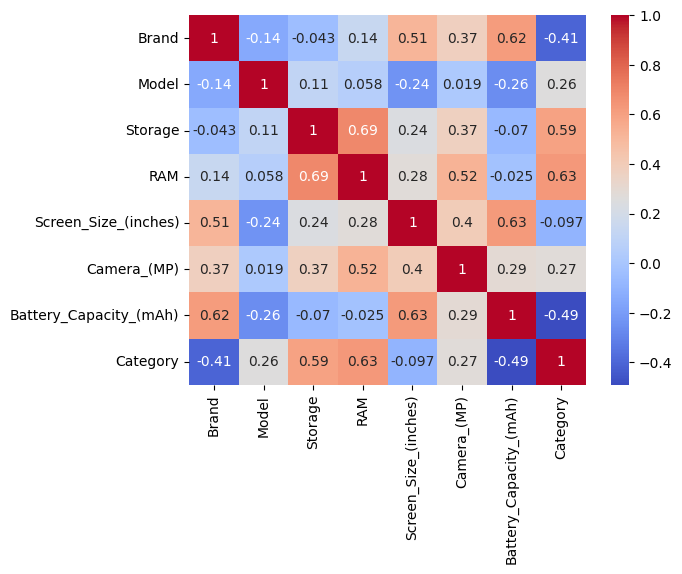

In [ ]:
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
data['Price_($)'].describe()

count     407.000000
mean      408.314496
std       299.684768
min        99.000000
25%       199.000000
50%       299.000000
75%       499.000000
max      1999.000000
Name: Price_($), dtype: float64

In [ ]:
#bersihin kolom
# data.columns = data.columns.str.strip()
# data.columns = data.columns.str.replace(' ', '_')

In [ ]:
# data["Camera_(MP)"] = data["Camera_(MP)"].str.replace("MP","")
# data["Camera_(MP)"] = data["Camera_(MP)"].str.replace("D","")

In [ ]:
# data["Camera_(MP)"] = data["Camera_(MP)"].str.split("+")

In [ ]:
# data = data.drop(['Model'], axis=1)

In [ ]:
data

,Brand,Model,Storage,RAM,Screen_Size_(inches),Camera_(MP),Battery_Capacity_(mAh),Price_($)
0,0,232,128,6,6.1,"[12 , 12 , 12]",3095,999
1,12,100,256,12,6.8,"[108 , 10 , 10 , 12]",5000,1199
2,9,19,128,8,6.7,"[48 , 50 , 8 , 2]",4500,899
3,15,178,128,6,6.67,"[64 , 8 , 5 , 2]",5020,279
4,4,162,128,8,6.4,"[50 , 12.2]",4614,799
...,...,...,...,...,...,...,...,...
402,12,95,128,8,6.7,"[12, 64, 12]",4300,1049
403,15,111,128,6,6.57,"[48, 8, 2, 2]",4160,349
404,0,229,128,6,6.7,"[12, 12, 12]",3687,1099
405,10,188,128,8,6.4,"[48, 13, 8, 2]",4025,429


In [ ]:
# data = data.drop(['Camera_1_MP', 'Camera_2_MP', 'Camera_3_MP', 'Camera_4_MP'], axis=1)

In [ ]:
# data = data[~(data["Screen_Size_(inches)"] == "7.6 (unfolded)")]
# data = data[~(data["Screen_Size_(inches)"] == "6.8 + 3.9")]
# data["Screen_Size_(inches)"] = data["Screen_Size_(inches)"].astype("float64")

In [ ]:
# listx = []
# for i in data.index:
#     listx.append(data["Camera_(MP)"][i][0])

# data["Camera_(MP)"] = listx
# data["Camera_(MP)"] = data["Camera_(MP)"].astype("float64")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 0 to 406
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Brand                   405 non-null    int64  
 1   Model                   405 non-null    int64  
 2   Storage                 405 non-null    int64  
 3   RAM                     405 non-null    int64  
 4   Screen_Size_(inches)    405 non-null    float64
 5   Camera_(MP)             405 non-null    float64
 6   Battery_Capacity_(mAh)  405 non-null    int64  
 7   Price_($)               405 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 44.6+ KB


In [ ]:
# data['Price_($)'] = data['Price_($)'].str.replace('$','')

In [ ]:
# data['Brand'] = data['Brand'].astype("float64")

In [ ]:
# data['Storage'] = data['Storage'].astype("float64")

In [ ]:
# data['RAM'] = data['RAM'].astype("float64")

In [ ]:
# data['Battery_Capacity_(mAh)'] = data['Battery_Capacity_(mAh)'].astype("float64")

In [ ]:
# data['Price_($)'] = data['Price_($)'].str.replace(',','')

In [ ]:
# data['Price_($)'] = data['Price_($)'].astype("float64")

In [ ]:
data

,Brand,Model,Storage,RAM,Screen_Size_(inches),Camera_(MP),Battery_Capacity_(mAh),Price_($)
0,0.0,232,128.0,6.0,6.10,12.0,3095.0,999.0
1,12.0,100,256.0,12.0,6.80,108.0,5000.0,1199.0
2,9.0,19,128.0,8.0,6.70,48.0,4500.0,899.0
3,15.0,178,128.0,6.0,6.67,64.0,5020.0,279.0
4,4.0,162,128.0,8.0,6.40,50.0,4614.0,799.0
...,...,...,...,...,...,...,...,...
402,12.0,95,128.0,8.0,6.70,12.0,4300.0,1049.0
403,15.0,111,128.0,6.0,6.57,48.0,4160.0,349.0
404,0.0,229,128.0,6.0,6.70,12.0,3687.0,1099.0
405,10.0,188,128.0,8.0,6.40,48.0,4025.0,429.0


In [ ]:
# features = data.drop(columns=['Price_($)'])
# target = data['Price_($)']

In [ ]:
# scaler = StandardScaler()
# features = scaler.fit_transform(features)

In [ ]:
# target_log = np.log1p(target)

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(degree=2, include_bias=False)
# features_poly = poly.fit_transform(features)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(features, target_log, test_size=0.2, random_state=42)

In [ ]:
# model = Sequential([
#     Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
#     Dropout(0.2),
#     Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
#     Dropout(0.2),
#     Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
#     Dropout(0.2),
#     Dense(1)
# ])

In [ ]:
max(data['Model'])

238

In [ ]:
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
# model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 40)                320       
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense_4 (Dense)             (None, 20)                820       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1161 (4.54 KB)
Trainable params: 1161 (4.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# history = model.fit(X_train, y_train, epochs=200, validation_split=0.2, batch_size=32, verbose=1)

Epoch 1/200
9/9 [==============================] - 1s 27ms/step - loss: 30.9887 - mae: 5.5032 - val_loss: 25.9618 - val_mae: 5.0393
Epoch 2/200
9/9 [==============================] - 0s 9ms/step - loss: 23.2667 - mae: 4.7379 - val_loss: 17.6829 - val_mae: 4.1132
Epoch 3/200
9/9 [==============================] - 0s 8ms/step - loss: 14.4293 - mae: 3.6221 - val_loss: 8.3959 - val_mae: 2.6709
Epoch 4/200
9/9 [==============================] - 0s 8ms/step - loss: 7.5880 - mae: 2.3887 - val_loss: 3.2058 - val_mae: 1.3217
Epoch 5/200
9/9 [==============================] - 0s 7ms/step - loss: 5.6364 - mae: 1.8327 - val_loss: 2.9396 - val_mae: 1.3476
Epoch 6/200
9/9 [==============================] - 0s 8ms/step - loss: 4.5794 - mae: 1.6792 - val_loss: 2.4286 - val_mae: 1.1938
Epoch 7/200
9/9 [==============================] - 0s 5ms/step - loss: 4.7046 - mae: 1.6612 - val_loss: 2.3634 - val_mae: 1.1850
Epoch 8/200
9/9 [==============================] - 0s 7ms/step - loss: 3.7101 - mae: 1.5723

In [ ]:
loss = model.evaluate(X_test, y_test)
print(f'Final loss: {loss}')

3/3 [==============================] - 0s 4ms/step - loss: 0.2796 - mae: 0.3277
Final loss: [0.27962037920951843, 0.3277122378349304]


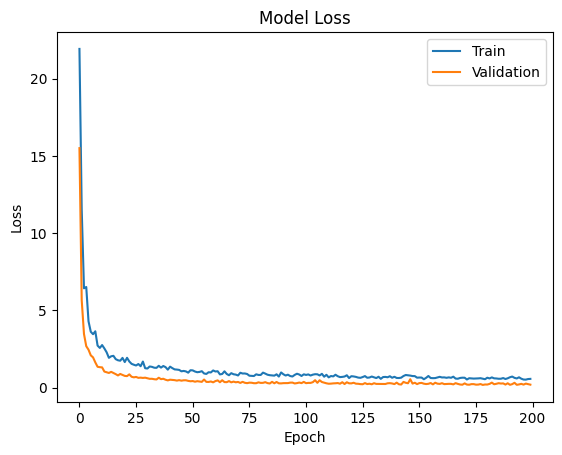

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)

3/3 [==============================] - 0s 3ms/step


In [ ]:
data.columns

Index(['Brand', 'Model', 'Storage', 'RAM', 'Screen_Size_(inches)',
       'Camera_(MP)', 'Battery_Capacity_(mAh)', 'Price_($)'],
      dtype='object')

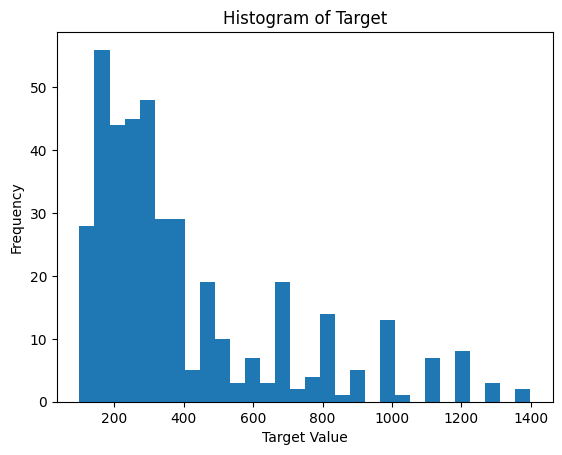

In [ ]:
import matplotlib.pyplot as plt

# Misalkan target adalah array atau seri dari target Anda
plt.hist(target, bins=30)
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.title('Histogram of Target')
plt.show()

In [ ]:
from scipy.stats import skew

# Menghitung skewness
target_skewness = skew(target)
print(f'Skewness of target: {target_skewness}')

Skewness of target: 1.437602187927131


In [ ]:
new_data_dict = {
    'Brand': ['Asus'],
    'Model': ['Zenfone 8 Flip'],
    'Storage': ['256 GB'],
    'RAM': ['8 GB'],
    'Screen_Size_(inches)': [6.67],
    'Camera_(MP)': [64],
    'Battery_Capacity_(mAh)':[5000]
}

new_data = pd.DataFrame(new_data_dict)

new_data['Brand'] = label_encoders['Brand'].transform(new_data['Brand'])
new_data['Model'] = label_encoders['Model'].transform(new_data['Model'])

new_data['Storage'] = new_data['Storage'].apply(convert_memory_size)
new_data['RAM'] = new_data['RAM'].apply(convert_memory_size)

new_data_normalized = scaler.transform(new_data)

predicted_log_price = model.predict(new_data_normalized)
predicted_price = np.expm1(predicted_log_price)

print(f'Predicted price: {predicted_price[0][0]}')

In [ ]:
# new_data = pd.DataFrame(new_data_dict)

In [ ]:
# new_data['Brand'] = label_encoders['Brand'].transform(new_data['Brand'])
# new_data['Model'] = label_encoders['Model'].transform(new_data['Model'])

In [ ]:
# new_data['Storage'] = new_data['Storage'].apply(convert_memory_size)
# new_data['RAM'] = new_data['RAM'].apply(convert_memory_size)

In [ ]:
# new_data_normalized = scaler.transform(new_data)

In [ ]:
# predicted_log_price = model.predict(new_data_normalized)
# predicted_price = np.expm1(predicted_log_price)

1/1 [==============================] - 0s 18ms/step


In [ ]:
# print(f'Predicted price: {predicted_price[0][0]}')

Predicted price: 595.2063598632812


Predictions: [[151.889  ]
 [213.56593]
 [326.3517 ]
 [224.8072 ]
 [149.2234 ]
 [321.50934]
 [333.8423 ]
 [287.91208]
 [181.11902]
 [250.1716 ]
 [642.9204 ]
 [326.3517 ]
 [123.35556]
 [163.18567]
 [156.1041 ]
 [119.00773]
 [275.6083 ]
 [432.81677]
 [657.635  ]
 [211.5443 ]
 [163.78113]
 [476.73715]
 [233.23459]
 [143.94669]
 [502.47293]
 [154.82138]
 [575.8034 ]
 [207.65924]
 [219.03978]
 [305.84045]
 [291.78683]
 [247.92113]
 [422.36752]
 [193.8621 ]
 [218.41376]
 [309.1381 ]
 [163.18567]
 [801.47314]
 [344.5478 ]
 [437.43347]
 [139.19478]
 [317.85202]
 [115.03202]
 [575.5864 ]
 [655.03314]
 [502.43622]
 [299.2625 ]
 [322.96417]
 [241.60187]
 [231.5796 ]
 [127.14865]
 [204.15656]
 [207.65924]
 [276.35876]
 [336.07834]
 [253.42418]
 [307.4697 ]
 [325.40918]
 [281.52563]
 [546.55054]
 [788.97205]
 [227.08568]
 [289.12515]
 [182.81252]
 [235.98856]
 [213.3747 ]
 [314.5141 ]
 [110.24742]
 [174.19894]
 [225.82312]
 [100.30241]
 [238.3745 ]
 [143.94669]
 [167.04892]
 [207.51712]
 [321.50934]

<ipython-input-141-c1858f19a102>:3: RuntimeWarning: overflow encountered in expm1
  print("Actual:", np.expm1(data.values))


**STOP**

In [ ]:
#bersihin kolom
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')

NameError: name 'df' is not defined

In [ ]:
df['Brand'].value_counts()

Brand
Samsung       79
Xiaomi        67
Oppo          56
Realme        43
Vivo          35
Apple         30
Nokia         28
Motorola      23
OnePlus       15
Huawei        12
Google         7
Asus           4
LG             3
Blackberry     3
Sony           1
CAT            1
Name: count, dtype: int64

In [ ]:
df.duplicated().sum()

26

In [ ]:
df

,Brand,Model,Storage,RAM,Screen_Size_(inches),Camera_(MP),Battery_Capacity_(mAh),Price_($)
0,Apple,iPhone 13 Pro,128 GB,6 GB,6.1,12 + 12 + 12,3095,999
1,Samsung,Galaxy S21 Ultra,256 GB,12 GB,6.8,108 + 10 + 10 + 12,5000,1199
2,OnePlus,9 Pro,128 GB,8 GB,6.7,48 + 50 + 8 + 2,4500,899
3,Xiaomi,Redmi Note 10 Pro,128 GB,6 GB,6.67,64 + 8 + 5 + 2,5020,279
4,Google,Pixel 6,128 GB,8 GB,6.4,50 + 12.2,4614,799
...,...,...,...,...,...,...,...,...
402,Samsung,Galaxy Note20 5G,128,8,6.7,12+64+12,4300,1049
403,Xiaomi,Mi 10 Lite 5G,128,6,6.57,48+8+2+2,4160,349
404,Apple,iPhone 12 Pro Max,128,6,6.7,12+12+12,3687,1099
405,Oppo,Reno3,128,8,6.4,48+13+8+2,4025,429


In [ ]:
baris_duplikat = df[df.duplicated()]
print(baris_duplikat)

        Brand                  Model Storage   RAM Screen_Size_(inches)  \
45      Apple         iPhone 12 Mini   64 GB  4 GB                  5.4   
61     Xiaomi         Poco M3 Pro 5G   64 GB  4 GB                  6.5   
132     Nokia                   XR20   128GB   6GB                 6.67   
170  Motorola       Moto G Stylus 5G   128GB   5GB                  6.8   
195      Oppo                 A74 5G   128GB   6GB                  6.5   
221      Vivo                   Y12s    32GB   3GB                 6.51   
229    Xiaomi  Redmi Note 10 Pro Max   128GB   8GB                 6.67   
240     Nokia               C20 Plus    32GB   3GB                  6.5   
246    Xiaomi            Poco X3 Pro   128GB   6GB                 6.67   
248      Oppo                    A16    32GB   3GB                 6.52   
260      Vivo                   Y12s    32GB   3GB                 6.51   
282   Samsung             Galaxy A12    64GB   4GB                  6.5   
331    Xiaomi            

In [ ]:
print(df.isna().sum())

Brand                     0
Model                     0
Storage                   0
RAM                       0
Screen_Size_(inches)      0
Camera_(MP)               0
Battery_Capacity_(mAh)    0
Price_($)                 0
dtype: int64


In [ ]:
df.dtypes

Brand                     object
Model                     object
Storage                   object
RAM                       object
Screen_Size_(inches)      object
Camera_(MP)               object
Battery_Capacity_(mAh)     int64
Price_($)                 object
dtype: object

In [ ]:
df['Storage'] = df['Storage'].str.replace('GB','')

In [ ]:
df['RAM'] = df['RAM'].str.replace('GB','')

In [ ]:
df['Storage'].tail()

402    128
403    128
404    128
405    128
406    128
Name: Storage, dtype: object

In [ ]:
df["Camera_(MP)"] = df["Camera_(MP)"].str.replace("MP","")
df["Camera_(MP)"] = df["Camera_(MP)"].str.replace("D","")

In [ ]:
print(df['Camera_(MP)'])

0            12 + 12 + 12
1      108 + 10 + 10 + 12
2         48 + 50 + 8 + 2
3          64 + 8 + 5 + 2
4               50 + 12.2
              ...        
402              12+64+12
403              48+8+2+2
404              12+12+12
405             48+13+8+2
406               48+12+5
Name: Camera_(MP), Length: 407, dtype: object


In [ ]:
df["Camera_(MP)"] = df["Camera_(MP)"].str.split("+")

In [ ]:
print(df['Camera_(MP)'])

0             [12 ,  12 ,  12]
1      [108 ,  10 ,  10 ,  12]
2         [48 ,  50 ,  8 ,  2]
3          [64 ,  8 ,  5 ,  2]
4                 [50 ,  12.2]
                ...           
402               [12, 64, 12]
403              [48, 8, 2, 2]
404               [12, 12, 12]
405             [48, 13, 8, 2]
406                [48, 12, 5]
Name: Camera_(MP), Length: 407, dtype: object


In [ ]:
listx = []
for i in df.index:
    listx.append(df["Camera_(MP)"][i][0])

df["Camera_(MP)"] = listx
df["Camera_(MP)"] = df["Camera_(MP)"].astype("float64")

In [ ]:
df["Camera_(MP)"] = listx


In [ ]:
df["Camera_(MP)"] = df["Camera_(MP)"].astype("float64")

In [ ]:
df['Screen_Size_(inches)'].unique()

array(['6.1', '6.8', '6.7', '6.67', '6.4', '6.55', '6.78', '6.43', '6.5',
       '6.62', '5.4', '6.2', '6.51', '6.6', '4.7', '6.58', '6.52', '6.44',
       '6.53', '6.56', '6.8 + 3.9', '4.5', '6.39', '5.9', '5.5', '6.81',
       '5.99', '6.82', '6.3', '6.22', '6', '6.35', '6.9', '6.76', '6.49',
       '6.72', '5.7', '6.47', '7.6 (unfolded)', '6.15', '6.57'],
      dtype=object)

In [ ]:
df = df[~(df["Screen_Size_(inches)"] == "6.8 + 3.9")]


In [ ]:
df["Screen_Size_(inches)"] = df["Screen_Size_(inches)"].astype("float64")


In [ ]:
df['Price_($)'] = pd.to_numeric(df['Price_($)'] , errors='coerce')


In [ ]:
df['Storage'] = pd.to_numeric(df['Storage'] , errors='coerce')


In [ ]:
df['RAM'] = pd.to_numeric(df['RAM'] , errors='coerce')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 0 to 406
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Brand                   405 non-null    object 
 1   Model                   405 non-null    object 
 2   Storage                 405 non-null    int64  
 3   RAM                     405 non-null    int64  
 4   Screen_Size_(inches)    405 non-null    float64
 5   Camera_(MP)             405 non-null    float64
 6   Battery_Capacity_(mAh)  405 non-null    int64  
 7   Price_($)               196 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 28.5+ KB


In [ ]:
df.shape

(405, 8)

In [ ]:
Mean_Price = df['Price_($)'].mean()
df['Price_($)'] = df['Price_($)'].fillna(Mean_Price)
df['Price_($)'].isnull().sum()


0

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()

In [ ]:
Brand = LabelEncoder()
Model = LabelEncoder()

In [ ]:
df['Brand'] = Brand.fit_transform(df['Brand'])

In [ ]:
df['Brand'].value_counts()


Brand
12    78
15    67
10    56
11    43
14    35
0     30
8     28
7     23
9     15
5     12
4      7
1      4
2      3
6      2
13     1
3      1
Name: count, dtype: int64

In [ ]:
df['Model'] = Model.fit_transform(df['Model'])


In [ ]:
max(df['Model'])

236

In [ ]:
X = df.drop('Price_($)', axis=1)
y = df['Price_($)']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(324, 7)

In [ ]:
X_test.shape

(81, 7)

In [ ]:
from scipy.stats import kurtosis, skew
print("Kurtosis:", kurtosis(df))
print("Skewness:", skew(df))

Kurtosis: [ 0.4791262  -1.28235289  9.1229469   0.93762237 18.416921    0.23605118
  2.07434686  2.7735876 ]
Skewness: [-1.03626745  0.03654801  2.11751345  0.96202142 -3.82247646  0.39728616
 -0.82255507  1.29805625]


In [ ]:
from sklearn.preprocessing import RobustScaler
ro_scaler = RobustScaler()
x_train = ro_scaler.fit_transform(X_train)
x_test = ro_scaler.fit_transform(X_test)

In [ ]:
print(x_train)

[[ 0.23529412 -0.38589212  0.         ...  0.          0.
   0.        ]
 [ 0.94117647  0.48547718  0.         ...  0.24489796  0.
   1.44927536]
 [ 0.94117647  0.52697095  0.         ...  1.3877551   0.31372549
   0.02898551]
 ...
 [-0.23529412 -0.69294606 -1.         ...  0.08163265 -0.68627451
   0.        ]
 [-0.94117647  0.17842324 -1.         ... -0.81632653 -0.62745098
   0.        ]
 [-0.47058824 -0.78423237  2.         ...  1.63265306  0.
  -0.72463768]]


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, input_shape=[X_train.shape[1]], activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/1000
11/11 [==============================] - 2s 23ms/step - loss: 808973.8750 - mae: 782.7282 - val_loss: 93202.0859 - val_mae: 219.8547
Epoch 2/1000
11/11 [==============================] - 0s 6ms/step - loss: 78725.7266 - mae: 224.9619 - val_loss: 92796.3750 - val_mae: 253.2857
Epoch 3/1000
11/11 [==============================] - 0s 6ms/step - loss: 71912.7188 - mae: 192.6902 - val_loss: 84282.2500 - val_mae: 203.7842
Epoch 4/1000
11/11 [==============================] - 0s 5ms/step - loss: 61219.4922 - mae: 165.9338 - val_loss: 77794.4844 - val_mae: 197.0870
Epoch 5/1000
11/11 [==============================] - 0s 5ms/step - loss: 60044.9492 - mae: 162.3006 - val_loss: 77953.9375 - val_mae: 189.6384
Epoch 6/1000
11/11 [==============================] - 0s 6ms/step - loss: 59945.9648 - mae: 161.7371 - val_loss: 77049.2344 - val_mae: 188.5699
Epoch 7/1000
11/11 [==============================] - 0s 7ms/step - loss: 59724.1562 - mae: 164.3644 - val_loss: 76052.2188 - val_mae:

KeyboardInterrupt: 

In [ ]:
x_train

array([[ 0.23529412, -0.38589212,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.94117647,  0.48547718,  0.        , ...,  0.24489796,
         0.        ,  1.44927536],
       [ 0.94117647,  0.52697095,  0.        , ...,  1.3877551 ,
         0.31372549,  0.02898551],
       ...,
       [-0.23529412, -0.69294606, -1.        , ...,  0.08163265,
        -0.68627451,  0.        ],
       [-0.94117647,  0.17842324, -1.        , ..., -0.81632653,
        -0.62745098,  0.        ],
       [-0.47058824, -0.78423237,  2.        , ...,  1.63265306,
         0.        , -0.72463768]])

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 324 entries, 356 to 103
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Brand                   324 non-null    int64  
 1   Model                   324 non-null    int64  
 2   Storage                 324 non-null    int64  
 3   RAM                     324 non-null    int64  
 4   Screen_Size_(inches)    324 non-null    float64
 5   Camera_(MP)             324 non-null    float64
 6   Battery_Capacity_(mAh)  324 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 20.2 KB


In [ ]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 324 entries, 356 to 103
Series name: Price_($)
Non-Null Count  Dtype  
--------------  -----  
324 non-null    float64
dtypes: float64(1)
memory usage: 5.1 KB
